# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

Предоставлен файл с следующими данными:

# Описание данных
- children — количество детей в семье
- days_employed — общий трудовой стаж в днях
- dob_years — возраст клиента в годах
- education — уровень образования клиента
- education_id — идентификатор уровня образования
- family_status — семейное положение
- family_status_id — идентификатор семейного положения
- gender — пол клиента
- income_type — тип занятости
- debt — имел ли задолженность по возврату кредитов
- total_income — ежемесячный доход
- purpose — цель получения кредита


# Структура проекта
1. [Изучение данных](#start)
2. [Предобработка данных](#preprocessing)
    * [Обработка пропущенных значений](#null)
    * [Обработка аномальных значений](#anomaly)  
    * [Замена типа данных](#type)
    * [Обработка дубликатов](#duplicates)
    * [Лематизация данных](#lemma)
    * [Категоризация данных](#category)
3. [Исследовательский анализ данных](#analysis)
4. [Построение моделей](#model)
5. [Вывод](#conclusion)

# Шаг 1. Изучение данных
<a id="start"></a>

На данном этапе познакомимся с данными. Посмотрим есть ли в данных дубликаты, пропуски, аномальные значения, неправильные типы данных.

Для начала импортируем необходимые библиотеки для работы над проектом. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
import phik
import time
from phik import resources, report
from phik.report import plot_correlation_matrix
import missingno as msno # импорт библиотеки missingno
import json
from pymystem3 import Mystem
from collections import Counter
import matplotlib.pyplot as plt
from phik import resources, report
from phik.report import plot_correlation_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier 


from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

Установим отсутствующие библиотеки.

In [2]:
!pip install phik
!pip install pymystem3


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Загрузим файл с данными.

In [3]:
data = pd.read_csv('data.csv')

Посмотрим, что содержится в датасете.

In [4]:
data.head(15)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Взглянув на датасет замечаем, что в нем есть:

- пропущенные значения 
- аномальные значения
- неправильные типы данных
- дубликаты 

Рассмотрим поподробнее. Изучим общую информацию о нем.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Столбцы `days_employed` и `total_income` неправильного типа данных, необходимо привести их к типу int. Также обнаружены пропущенные значения в этих столбцах `days_employed` и `total_income`. Посмотрим на процентное соотношение пропусков.

In [6]:
data.isnull().mean().sort_values(ascending=False)

days_employed       0.100999
total_income        0.100999
children            0.000000
dob_years           0.000000
education           0.000000
education_id        0.000000
family_status       0.000000
family_status_id    0.000000
gender              0.000000
income_type         0.000000
debt                0.000000
purpose             0.000000
dtype: float64

Пропущенные значения занимают 10% от датасета. Видим, что кол-во пропущенных значений в столбцах совпадают. Также заметили, что пропуски есть в обоих столбцах. Причины пропусков скорее всего не случайны. Возможно связаны с сокрытием информации. Например клиент мог взять кредит без подтверждения дохода по двум документам. Построим матрицу пропущенных значений. 

<AxesSubplot:>

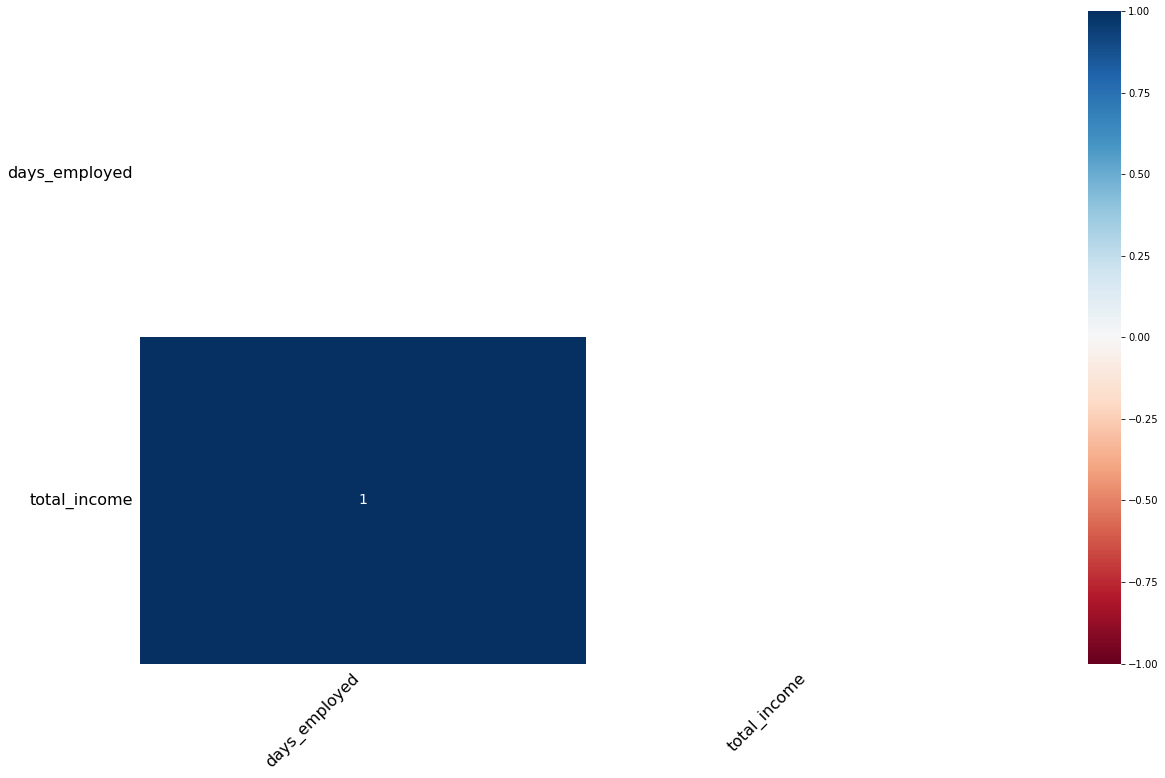

In [7]:
msno.heatmap(data)

Как мы и думали, все пропущенные значения совпадают в обоих столбцах. Причины пропусков явно не случайны.

Посмотрим на распределение данных в столбцах.

In [8]:
data.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


Видим, что в столбцах `children`, `days_employed ` есть аномальные значения.

Проверим, есть ли в данных некорректные значения, неявные дубликаты. Посмотрим на уникальные значения во всех столбцах.

In [9]:
for columns in data.columns:
    display(columns, data[columns].unique())

'children'

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

'days_employed'

array([-8437.67302776, -4024.80375385, -5623.42261023, ...,
       -2113.3468877 , -3112.4817052 , -1984.50758853])

'dob_years'

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51,  0, 59, 29, 60, 55, 58, 71, 22, 73,
       66, 69, 19, 72, 70, 74, 75], dtype=int64)

'education'

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

'education_id'

array([0, 1, 2, 3, 4], dtype=int64)

'family_status'

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

'family_status_id'

array([0, 1, 2, 3, 4], dtype=int64)

'gender'

array(['F', 'M', 'XNA'], dtype=object)

'income_type'

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

'debt'

array([0, 1], dtype=int64)

'total_income'

array([253875.6394526 , 112080.01410244, 145885.95229686, ...,
        89672.56115303, 244093.05050043,  82047.41889948])

'purpose'

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Замечаем, что есть неккоректные значения в столбцах `children`, например -1, 20. В столбце `gender` неизвестное значение 'XNA'. Также видим дубликаты в данных, в столбце `education` из-за различного регистра, например 'НАЧАЛЬНОЕ' 'Начальное',  и в столбце purpose из-за отсутствия лемматизации слов, например 'сыграть свадьбу' и  'на проведение свадьбы'. 

## **Вывод**

В результате анализа данных обнаружили:
- в столбцах `days_employed` и `total_income` пропущены значения. Причины пропусков скорее всего не случайны. Возможно это связано с сокрытием информации. Необходимо обработать пропуски.
- в столбце `education` дубликаты, т.к данные представлены в разных регистрах: в верхнем и нижнем. Необходимо привести столбец к единому нижнему регистру.
- в столбце `purpose` дублируются данные, например на проведение свадьбы и сыграть свадьбу. Необходимо лемматизировать значения.
- в столбцах `days_employed` и `total_income` некорректный тип данных float, который нужно заменить на int.
- в столбцах `days_employed`,`dob_years`,`children` неккоректные значения. Необходимо обработать данные.

# Шаг 2. Предобработка данных
<a id="preprocessing"></a>

На данном этапе обработаем данные:
- избавимся от пропусков 
- удалим дубликаты
- обработаем аномальные значения
- приведем данные к нужному типу 

## Обработка пропусков
<a id="null"></a>

Как мы уже выяснили, в столбцах days_employed и total_income пропущены значения. Необходимо обработать пропущенные значения. Либо удалить, либо заполнить каким-то значением. 

Посмотрим на матрицу корреляции.

In [10]:
phik_overview = data.phik_matrix()
phik_overview

interval columns not set, guessing: ['children', 'days_employed', 'dob_years', 'education_id', 'family_status_id', 'debt', 'total_income']


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
children,1.000000,0.116614,0.255190,0.029776,0.007694,0.098733,0.098733,0.026507,0.203771,0.016899,0.007682,0.032290
days_employed,0.116614,1.000000,0.781338,0.203581,0.124125,0.202052,0.202052,0.317309,0.788142,0.028523,0.132720,0.000000
dob_years,0.255190,0.781338,1.000000,0.188952,0.185947,0.281225,0.281225,0.213078,0.481244,0.068791,0.081912,0.000000
education,0.029776,0.203581,0.188952,1.000000,1.000000,0.129056,0.129056,0.060869,0.185330,0.062447,0.158946,0.000000
education_id,0.007694,0.124125,0.185947,1.000000,1.000000,0.144882,0.144882,0.041644,0.170108,0.047200,0.160430,0.000000
family_status,0.098733,0.202052,0.281225,0.129056,0.144882,1.000000,1.000000,0.143941,0.179178,0.027480,0.027813,0.632444
family_status_id,0.098733,0.202052,0.281225,0.129056,0.144882,1.000000,1.000000,0.143941,0.179178,0.027480,0.027813,0.632444
gender,0.026507,0.317309,0.213078,0.060869,0.041644,0.143941,0.143941,1.000000,0.184467,0.033683,0.198377,0.000000
income_type,0.203771,0.788142,0.481244,0.185330,0.170108,0.179178,0.179178,0.184467,1.000000,0.084127,0.129032,0.000000
debt,0.016899,0.028523,0.068791,0.062447,0.047200,0.027480,0.027480,0.033683,0.084127,1.000000,0.018616,0.032122


Рассмотрим тепловую карту, чтобы нагляднее рассмотреть зависимости между признаками.

<AxesSubplot:>

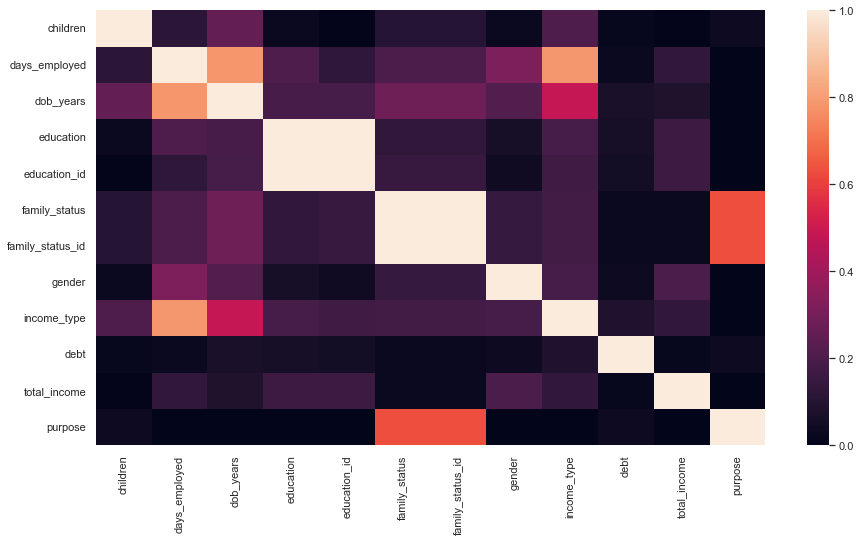

In [11]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(phik_overview)

Нас интересуют только столбцы с пропусками. Отсортируем по убыванию зависимость данных в пропущенных столбцах.

In [12]:
phik1 = phik_overview['days_employed'].sort_values(ascending=False)
phik1

days_employed       1.000000
income_type         0.788142
dob_years           0.781338
gender              0.317309
education           0.203581
family_status_id    0.202052
family_status       0.202052
total_income        0.132720
education_id        0.124125
children            0.116614
debt                0.028523
purpose             0.000000
Name: days_employed, dtype: float64

Видим, что общий трудовой стаж сильно зависит от типа занятости и возраста заемщика. 

In [13]:
phik2 = phik_overview['total_income'].sort_values(ascending=False)
phik2

total_income        1.000000
gender              0.198377
education_id        0.160430
education           0.158946
days_employed       0.132720
income_type         0.129032
dob_years           0.081912
family_status       0.027813
family_status_id    0.027813
debt                0.018616
children            0.007682
purpose             0.000000
Name: total_income, dtype: float64

С ежемесячным доходом другая ситуация. Замечаем, что корреляция слабая. Больше всего ежемесячный доход зависит от пола. Очень интересно.

In [14]:
data_transformed_income = data.groupby('income_type')['total_income'].transform('mean')
data['total_income'] = data['total_income'].fillna(data_transformed_income)

Можно заменить пропуски в столбце days_employed средним значением по типу занятости. Но пропуски в столбце total_income заменить средним значением не получится из-за небольшой корреляции. Так как пропущенные значения отсутствуют в обоих столбцах, процент пропущенных значений небольшой, мы можем удалить пропуски. 

In [15]:
#data_transformed_days = data.groupby('income_type')['days_employed'].transform('mean')
#data['days_employed'] = data['days_employed'].fillna(data_transformed_days)

In [16]:
data = data.dropna()

Проверим пропуски снова.

In [17]:
data.isnull().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

Пропущенные значения удалили.

## Обработка аномалий
<a id="anomaly"></a>

Как мы уже знаем, что в столбцах `days_employed `,`children`,`dob_years`,`gender` есть аномальные значения. Рассмотрим подробнее столбец `days_employed `. Cгруппируем столбец по `income_type`. 

In [18]:
mean_days_employed = data.groupby(['income_type']).agg({'days_employed':'mean'})
display(mean_days_employed)

,days_employed
income_type,
безработный,366413.652744
в декрете,-3296.759962
госслужащий,-3399.896902
компаньон,-2111.524398
пенсионер,365003.491245
предприниматель,-520.848083
сотрудник,-2326.499216
студент,-578.751554


Замечаем, что аномально большие значения находятся в строках 'пенсионеры' и 'безработные' при этом все значения положительные, в остальных столбцах значения в пределах нормы, но при этом орицательные. Отрицательные данные в столбцах могли возникнуть, потому что у пенсионеров и безработных есть дата завершения работы, а у работающих ее нет. Аномально большие значения могли возникнуть из-за ошибки ввода формата данных, например некоторые значения рассчитывались по дням, другие по часам.

 Приведем отрицательные значения к положительным с помощью модуля.

In [19]:
data['days_employed'] = data['days_employed'].abs()

Теперь разберемся с аномально большими значениями. Мы заметили, что у безработных и пенсионеров данные отличаются от других типов занятости. Рассмотрим распределение данных в столбцах по этим типам занятости.

In [20]:
data[data['income_type']=='безработный'].describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.500000,366413.652744,38.000000,0.500000,0.500000,0.500000,131339.751676
std,0.707107,40855.478519,9.899495,0.707107,0.707107,0.707107,100950.466876
min,0.000000,337524.466835,31.000000,0.000000,0.000000,0.000000,59956.991984
25%,0.250000,351969.059790,34.500000,0.250000,0.250000,0.250000,95648.371830
50%,0.500000,366413.652744,38.000000,0.500000,0.500000,0.500000,131339.751676
75%,0.750000,380858.245699,41.500000,0.750000,0.750000,0.750000,167031.131522
max,1.000000,395302.838654,45.000000,1.000000,1.000000,1.000000,202722.511368


Видим, что всего лишь 2 безработных человека в выборке. Ориентироваться на эти данные не можем. Посмотрим на распределение данных у пенсионеров.

In [21]:
data[data['income_type']=='пенсионер'].describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,3443.000000,3443.000000,3443.000000,3443.000000,3443.000000,3443.000000,3443.000000
mean,0.128086,365003.491245,59.137090,0.914900,0.984606,0.052570,137127.465690
std,0.955201,21069.606065,7.563777,0.517016,1.316346,0.223207,80246.953231
min,-1.000000,328728.720605,0.000000,0.000000,0.000000,0.000000,20667.263793
25%,0.000000,346649.346146,56.000000,1.000000,0.000000,0.000000,82881.443465
50%,0.000000,365213.306266,60.000000,1.000000,0.000000,0.000000,118514.486412
75%,0.000000,383231.396871,64.000000,1.000000,2.000000,0.000000,169700.433010
max,20.000000,401755.400475,74.000000,4.000000,4.000000,1.000000,735103.270167


Видим, что среднее значение трудового стажа у пенсионеров составляет примерно 365000, средний возраст 59 лет. Допустим, если все пенсионеры начали работать в 18 лет, то их трудовой стаж в годах составляет в среднем 41 год, в днях 14 965, но явно не 365000. Если мы разделим 365000 на 14 965, то получим значение 24,3. Как мы и предполагали, трудовой стаж для пенсионеров и безработных рассчитывали по часам, а не по дням, как это было указано. Разделим значения для данных категорий на 24. 

In [22]:
def h_to_days(row):
    if row['income_type'] == 'безработный' or row['income_type'] == 'пенсионер':
        row['days_employed']= row['days_employed']/24
    return row['days_employed']
data['days_employed'] = data.apply(h_to_days, axis=1)

Проверим, как отработала функция.

In [23]:
data[data['income_type']=='пенсионер'].describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,3443.000000,3443.000000,3443.000000,3443.000000,3443.000000,3443.000000,3443.000000
mean,0.128086,15208.478802,59.137090,0.914900,0.984606,0.052570,137127.465690
std,0.955201,877.900253,7.563777,0.517016,1.316346,0.223207,80246.953231
min,-1.000000,13697.030025,0.000000,0.000000,0.000000,0.000000,20667.263793
25%,0.000000,14443.722756,56.000000,1.000000,0.000000,0.000000,82881.443465
50%,0.000000,15217.221094,60.000000,1.000000,0.000000,0.000000,118514.486412
75%,0.000000,15967.974870,64.000000,1.000000,2.000000,0.000000,169700.433010
max,20.000000,16739.808353,74.000000,4.000000,4.000000,1.000000,735103.270167


Аномальных значений в столбце income_type больше нет. Также в столбце children замечали аномалии. Проверим все значения столбца children.

In [24]:
data['children'].value_counts()

 0     12710
 1      4343
 2      1851
 3       294
 20       67
-1        44
 4        34
 5         8
Name: children, dtype: int64

В столбце `children` обнаружены аномальные значения: -1, 20. Ошибочные значения возможно связаны с опечатками при вводе данных. Заменим данные с ошибками на корректные значения.

In [25]:
data['children'] = data['children'].replace(20, 2)
data['children'] = data['children'].replace(-1, 1)

Проверим все значения столбца dob_years и отсортируем их по возрастанию.

In [26]:
data['dob_years'].value_counts().sort_index()

0      91
19     13
20     46
21     93
22    166
23    218
24    243
25    334
26    373
27    457
28    446
29    495
30    482
31    495
32    473
33    530
34    534
35    553
36    492
37    484
38    544
39    522
40    543
41    548
42    532
43    463
44    503
45    447
46    427
47    421
48    492
49    458
50    463
51    398
52    431
53    415
54    424
55    395
56    433
57    404
58    405
59    410
60    338
61    317
62    314
63    240
64    228
65    174
66    163
67    151
68     90
69     80
70     62
71     53
72     31
73      7
74      6
75      1
Name: dob_years, dtype: int64

Обнаружена ошибка в столбце `dob_years` с некорректным значением - 0. Не может быть младенец заемщиком в банке. Возможно нулем был обозначен пропуск в данных. Необходимо написать функцию для замены ошибочного значения средним значением по столбцу `income_type`.

In [27]:
data_grouped = data.groupby('income_type')['dob_years'].mean()
def func(row):
    if row['dob_years'] == 0:
        return data_grouped.loc[row['income_type']]
    return row['dob_years']
data['dob_years'] = data.apply(func, axis=1)
data['dob_years'] = data['dob_years'].astype('int')

Проверим работу функции.

In [28]:
print(data[data['dob_years']==0]['dob_years'])

Series([], Name: dob_years, dtype: int32)


Теперь все в порядке. Изучим значения столбца gender.

In [29]:
data['gender'].value_counts()

F      12752
M       6598
XNA        1
Name: gender, dtype: int64

Обнаружено 1 неккоректное значение 'XNA'. Удалим его из выборки датафрейма.

In [30]:
data = data[data['gender'] != 'XNA']

Проверим снова значения в столбце gender.

In [31]:
data['gender'].value_counts()

F    12752
M     6598
Name: gender, dtype: int64

**Вывод** 

В столбцах `days_employed` и `total_income` обнаружены пропуски и заполнены средним значением, cгрупированным по столбцу `income_type`.

## Замена типа данных
<a id="type"></a>

Исходя из общей информации о таблице, мы заметили, что два столбца имеют вещественный тип данных, который и надо заменить на целочисленный. Заменим тип данных в столбцах `days_employed`, `total_income` с float на int. Для этого воспользуемся методом astype(). Аргумент ('int') метода astype() означает, что значение нужно перевести в целое число:


In [32]:
data['days_employed'] = data['days_employed'].astype('int')
data['total_income'] = data['total_income'].astype('int')

Проверим замену типа данных.

In [33]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19350 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          19350 non-null  int64 
 1   days_employed     19350 non-null  int32 
 2   dob_years         19350 non-null  int32 
 3   education         19350 non-null  object
 4   education_id      19350 non-null  int64 
 5   family_status     19350 non-null  object
 6   family_status_id  19350 non-null  int64 
 7   gender            19350 non-null  object
 8   income_type       19350 non-null  object
 9   debt              19350 non-null  int64 
 10  total_income      19350 non-null  int32 
 11  purpose           19350 non-null  object
dtypes: int32(3), int64(4), object(5)
memory usage: 1.7+ MB


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,14177,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу


Осуществили замену типов данных.

**Вывод** 

Осуществлена замена типа данных в столбцах `days_employed`, `total_income` с float на int.

## Обработка дубликатов
<a id="duplicates"></a>

При знакомстве с данными мы обнаружили неявные дубликаты. Проверим наличие явных дубикатов в датафрейме. А также избавимся от всех дубликатов в данных.

### Обработка явных дубликатов

Посчитаем количество явных дубликатов в датафрейме.

In [34]:
data.duplicated().sum()

0

Причинами явных дубликатов могут быть ошибки ввода данных. Удалим явные дубликаты из датафрейма.

In [35]:
data = data.drop_duplicates().reset_index(drop=True)

Проверим удаление дубликатов

In [36]:
data.duplicated().sum()

0

### Обработка неявных дубликатов

При изучении файла обнаружили неявные дубликаты в столбце `education` из-за различного регистра. Выведем на экран уникальные значения из столбца `education`.

In [37]:
data['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

Чтобы устранить такие дубликаты, все символы в строке приведем к нижнему регистру c вызовом метода str.lower():

In [38]:
data['education'] = data['education'].str.lower()

Проверим уникальные значения из столбца `education`

In [39]:
data['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

In [40]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,14177,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу


**Вывод**

Выявили и устранили явные и неявные дубликаты во всех столбцах датасета. При поиске дубликатов обнаружены аномальные значения, которые были обработаны.

## Лемматизация
<a id="lemma"></a>

В столбце purpose обнаружили неявные дубликаты. Необходимо лемматизировать значения в данном столбце. Изучим уникальные значения из столбца `purpose`.

In [41]:
data['purpose'].value_counts()

свадьба                                   721
сыграть свадьбу                           693
на проведение свадьбы                     685
операции с недвижимостью                  615
покупка коммерческой недвижимости         597
покупка жилья                             595
покупка жилья для сдачи                   588
жилье                                     587
операции с коммерческой недвижимостью     581
строительство жилой недвижимости          580
операции с жильем                         579
покупка своего жилья                      574
недвижимость                              572
покупка жилья для семьи                   570
строительство недвижимости                561
строительство собственной недвижимости    560
операции со своей недвижимостью           559
покупка недвижимости                      551
покупка жилой недвижимости                546
ремонт жилью                              542
автомобиль                                454
на покупку своего автомобиля      

Необходимо написать функцию для лемматизации значений, т.к данные в столбце `purpose` дублируются, например 'свадьба', 'на проведение свадьбы', 'cыграть свадьбу'.
Просмотрев уникальные значения из столбца `purpose` делаем вывод, 
что необходимо сформировать 6 видов целей кредита: 'жилье', 'свадьба', 'автомобиль', 'образование', 'недвижимость', 'строительство'.

In [42]:
m = Mystem()
purpose_mass_string = ''
def lemma(purpose):
    global purpose_mass_string
    if purpose_mass_string:
        purpose_mass_string += '|'
    purpose_mass_string += purpose
  
    
data['purpose_lem'] = data['purpose'].apply(lemma)

lem_purposes = '' .join(m.lemmatize(purpose_mass_string)).split('|')

def lemma2(purpose):
    global lem_purposes
    lem_purpose = lem_purposes.pop(0)
    purpose_lem_arr = ["жилье", "свадьба", "автомобиль","образование","недвижимость","строительство"]
    for lem_purpose_word in purpose_lem_arr:
        if lem_purpose_word in lem_purpose:
            return lem_purpose_word

data['purpose_lem'] = data['purpose'].apply(lemma2)  

Проверим работу функции.

In [43]:
data.head(15)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lem
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,жилье
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,автомобиль
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,жилье
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,образование
4,0,14177,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,свадьба
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья,жилье
6,0,2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240525,операции с жильем,жилье
7,0,152,50,среднее,1,женат / замужем,0,M,сотрудник,0,135823,образование,образование
8,2,6929,35,высшее,0,гражданский брак,1,F,сотрудник,0,95856,на проведение свадьбы,свадьба
9,0,2188,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425,покупка жилья для семьи,жилье


**Вывод**

При анализе столбца `purpose` были обнаружены неявные дубликаты, например 'свадьба', 'на проведение свадьбы', 'cыграть свадьбу'. Данную проблему решили применением функции с лемматизацией столбца `purpose`, в новом столбце `purpose_lem` cформировано 6 целей кредита: 'жилье', 'свадьба', 'автомобиль', 'образование', 'недвижимость', 'строительство'.

## Категоризация данных
<a id="category"></a>

Для анализа зависимости между уровнем дохода и возвратом кредита в срок потребуется категоризовать данные. Необходимо написать функцию, которая сформирует несколько групп дохода в зависимости от уровня ежемесячного дохода. Для начала необходимо распределить группы дохода. Функция qcut разделит данные на 4 интервала равного размера.

In [44]:
qcut = pd.qcut(data['total_income'], 4)
print(qcut)

0        (203423.5, 2265604.0]
1         (103040.5, 145011.0]
2         (145011.0, 203423.5]
3        (203423.5, 2265604.0]
4         (145011.0, 203423.5]
                 ...          
19345    (203423.5, 2265604.0]
19346     (145011.0, 203423.5]
19347    (20666.999, 103040.5]
19348    (203423.5, 2265604.0]
19349    (20666.999, 103040.5]
Name: total_income, Length: 19350, dtype: category
Categories (4, interval[float64, right]): [(20666.999, 103040.5] < (103040.5, 145011.0] < (145011.0, 203423.5] < (203423.5, 2265604.0]]


Получилось 4 категории дохода, которые мы определим как 1.Доход низкий (от 20666 до 103040) 2. Доход средний (от 103040 до 145011) 3. Доход выше среднего (от 145011 до 203424) 4. Доход высокий (от 203424 и выше)

In [45]:
def income_cat(row):
    
    income = row['total_income']

    if 20666<= income <=103040:
        return 'Доход низкий'
    
    elif  103040<= income <= 145011:
        return 'Доход средний'
    
    elif 145011<= income <= 203424:
        return 'Доход выше среднего'
    
    else:
        return 'Доход высокий'

data['income_cat'] = data.apply(income_cat, axis=1)


In [46]:
data

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lem,income_cat
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,жилье,Доход высокий
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,автомобиль,Доход средний
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,жилье,Доход выше среднего
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,образование,Доход высокий
4,0,14177,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,свадьба,Доход выше среднего
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19345,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем,жилье,Доход высокий
19346,0,14330,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем,автомобиль,Доход выше среднего
19347,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость,недвижимость,Доход низкий
19348,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля,автомобиль,Доход высокий


Еще мы заметили, что между признаками education и education_id, а также family_status и family_status_id сильная корреляция. Мультиколлинеарность негативно влияет на модели машинного обучения. Поэтому определим и выделим словари в данных признаках. 

In [47]:
education = data.set_index('education_id')['education'].to_dict()
education

{0: 'высшее',
 1: 'среднее',
 2: 'неоконченное высшее',
 3: 'начальное',
 4: 'ученая степень'}

In [48]:
family_status = data.set_index('family_status_id')['family_status'].to_dict()
family_status

{0: 'женат / замужем',
 1: 'гражданский брак',
 2: 'вдовец / вдова',
 3: 'в разводе',
 4: 'Не женат / не замужем'}

А столбцы с текстовой информации можно удалить, чтобы было удобнее работать с данными и исключить мультиколлинеарность.

In [49]:
#data = data.drop(['education', 'family_status'], axis=1) 

**Вывод**

Для категоризации данных мы использовали функцию дискретизации на основе квантилей, которая определила 4 равных интервала уровня дохода. Затем мы написали функцию, которая формирует новый столбец с информацией о уровне дохода: низкий, средний, выше среднего, высокий.

In [50]:
qcut = pd.qcut(data['days_employed'], 4)
print(qcut)

0        (5537.5, 18388.0]
1         (2194.0, 5537.5]
2        (5537.5, 18388.0]
3         (2194.0, 5537.5]
4        (5537.5, 18388.0]
               ...        
19345     (2194.0, 5537.5]
19346    (5537.5, 18388.0]
19347     (926.25, 2194.0]
19348     (2194.0, 5537.5]
19349     (926.25, 2194.0]
Name: days_employed, Length: 19350, dtype: category
Categories (4, interval[float64, right]): [(23.999, 926.25] < (926.25, 2194.0] < (2194.0, 5537.5] < (5537.5, 18388.0]]


In [51]:
def emission(data, column):
    q1 = data[column].quantile(q=0.25)
    q3 = data[column].quantile(q=0.75)
    norm = data.loc[(data[column] < q3 + 1.5*(q3 - q1)) & (data[column] > q1 - 1.5*(q3-q1)), column]
    return norm
emission_list = ['days_employed']
for item in emission_list:
    data[item] = emission(data, item)

In [52]:
data.isnull().sum()

children               0
days_employed       3516
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income           0
purpose                0
purpose_lem            0
income_cat             0
dtype: int64

In [53]:
data = data.dropna()

# Шаг 3. Исследовательский анализ данных
<a id="analysis"></a>

Найдем ответы на следующие вопросы.

 - **Есть ли зависимость между наличием детей и возвратом кредита в срок?**
 

Выведем на экран процент задолженности по возврату кредитов в зависимости от кол-ва детей.

In [54]:
d1 = data.pivot_table(index=['debt'], columns='children', values = 'family_status_id', aggfunc='count').T
d1['debt'] = d1[1]/(d1[0]+d1[1])
d1.set_axis(['no_debt', 'yes_debt','%debt'], axis='columns', inplace=True) #Замена названий столбцов 
d1['%debt'] = d1['%debt'].fillna(0)
d1['yes_debt'] = d1['yes_debt'].fillna(0)
d1 = d1.sort_values(by='%debt')
d1 = d1.style.format({'no_debt': "{:.0f}",'yes_debt': "{:.0f}",'%debt': "{:.2%}"})
d1

,no_debt,yes_debt,%debt
children,,,
5,8,0,0.00%
3,267,21,7.29%
0,8706,784,8.26%
4,30,3,9.09%
1,3725,397,9.63%
2,1710,183,9.67%


**Вывод**

В результе анализа замечаем, что 
- большинство заемщиков не имеют детей. 
- с увеличением кол-ва детей кол-во заемщиков становится меньше. Это вполне логично. 
- среди многодетных детей (от 3-х детей) процент должников ниже, чем у заемщиков с 1 или 2 детьми. 
- процент возврата долга у самых многодетных людей (5 детей) самый низкий - 0 %

В среднем появление ребенка увеличивает возможность просрочки платежа по кредиту. Так процент должников среди бездетных заемщиков ниже, чем у заемщиков с 1 ребенком. А процент должников среди заемщиков с 1 ребенком ниже, чем у заемщиков с 2 детьми. Однако увеличение кол-ва детей в семье не увеличивает возможность долга по кредиту, например, среди многодетных семей с 3, 4, 5 детьми, долгов меньше, чем у семей с 1, 2 детьми. При этом кол-во многодетных заемщиков значительно ниже, чем остальных, этим и объясняется низкий процент должников. 

- **Есть ли зависимость между семейным положением и возвратом кредита в срок?**

Выведем на экран процент задолженности по возврату кредитов в зависимости от семейного положения

In [55]:
data_pivot2 = data.pivot_table(index=['debt'], columns='family_status', values = 'family_status_id', aggfunc='count').T
data_pivot2['debt'] = data_pivot2[1]/(data_pivot2[0]+data_pivot2[1])
d2 = data_pivot2.sort_values(by='debt')
d2.set_axis(['no_debt', 'yes_debt','%debt'], axis='columns', inplace=True) #Замена названий столбцов 
d2 = d2.style.format({'no_debt': "{:.0f}",'yes_debt': "{:.0f}",'%debt': "{:.2%}"})
d2

,no_debt,yes_debt,%debt
family_status,,,
вдовец / вдова,352,24,6.38%
в разводе,818,65,7.36%
женат / замужем,8472,748,8.11%
гражданский брак,2839,310,9.84%
Не женат / не замужем,1965,241,10.92%


**Вывод**

В результе анализа замечаем, что:
- большинство заемщиков женаты/замужем.
- процент должников среди людей, которые на данный момент замужем или когда-то были замужем меньше, по сравнению с людьми без штампа в паспорте. 
- самый большой процент должников среди неженатых/незамужних людей и людей в гражданскои браке.

Зависимость между семейным положением и возвратом кредита в срок существует. Люди без штампа в паспорте меньше выплачивают кредит в срок, чем люди в браке или которые были когда-то в браке.


- **Есть ли зависимость между уровнем дохода и возвратом кредита в срок?**

Выведем на экран процент задолженности по возврату кредитов в зависимости от уровня дохода

In [56]:
data_pivot3 = data.pivot_table(index=['debt'], columns='income_cat', values = 'family_status_id', aggfunc='count').T
data_pivot3['debt'] = data_pivot3[1]/(data_pivot3[0]+data_pivot3[1])
d3 = data_pivot3.sort_values(by='debt')
d3.set_axis(['no_debt', 'yes_debt','%debt'], axis='columns', inplace=True) #Замена названий столбцов 
d3 = d3.style.format({'no_debt': "{:.0f}",'yes_debt': "{:.0f}",'%debt': "{:.2%}"})
d3

,no_debt,yes_debt,%debt
income_cat,,,
Доход высокий,3994,311,7.22%
Доход низкий,3145,317,9.16%
Доход выше среднего,3738,382,9.27%
Доход средний,3569,378,9.58%


**Вывод**

В результе анализа замечаем, что:
- кол-во людей в группах по уровню дохода примерно одинаковое
- процент должников среди людей с наибольшим доходом самый низкий
- люди с низким доходом выплачивают кредит в срок лучше, чем люди с средним и выше среднего достатком.

Прямой зависимости между задолженности по возврату кредитов в зависимости от уровня дохода не обнаружили. Но среди людей с высоким доходом меньше всего должников. 

- **Как разные цели кредита влияют на его возврат в срок?**

Выведем на экран процент задолженности по возврату кредитов в зависимости от цели кредита

In [57]:
data_pivot4 = data.pivot_table(index=['debt'], columns='purpose_lem', values = 'family_status_id', aggfunc='count').T
data_pivot4['debt'] = data_pivot4[1]/(data_pivot4[0]+data_pivot4[1])
d4 = data_pivot4.sort_values(by='debt')
d4.set_axis(['no_debt', 'yes_debt','%debt'], axis='columns', inplace=True) #Замена названий столбцов 
d4 = d4.style.format({'no_debt': "{:.0f}",'yes_debt': "{:.0f}",'%debt': "{:.2%}"})
d4

,no_debt,yes_debt,%debt
purpose_lem,,,
жилье,3082,249,7.48%
свадьба,1579,139,8.09%
недвижимость,4298,388,8.28%
образование,2643,289,9.86%
автомобиль,2844,323,10.20%


**Вывод**

В результе анализа замечаем, что:
- люди с большей вероятностью выплачивают кредит, если он взят на жилье
- люди с меньшей вероятностью выплачивают кредит, если он взят на автомобиль


# Шаг 4. Построение моделей
<a id="model"></a>

Задача проекта: построить модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку. Это задача классификации. Поэтому мы будем применять в работе такие модели, как CatBoostClassifier, LGBMClassifier, DecisionTreeClassifier, RandomForestClassifier. Искать гиперпараметры будем с помощью функции GridSearchCV.
Для начала подготовим данные для построения моделей:
- определим есть ли дисбаланс в классах 
- определим признаки 
- разделим данные на выборки 
- закодируем категориальные признаки
- масштабируем численные признаки

Удалим из данных ненужные столбцы.

In [58]:
data = data.drop(['education', 'family_status','purpose'], axis=1) 

Посмотрим общую информацию. Убедимся, что все на месте.

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15834 entries, 0 to 19349
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          15834 non-null  int64  
 1   days_employed     15834 non-null  float64
 2   dob_years         15834 non-null  int32  
 3   education_id      15834 non-null  int64  
 4   family_status_id  15834 non-null  int64  
 5   gender            15834 non-null  object 
 6   income_type       15834 non-null  object 
 7   debt              15834 non-null  int64  
 8   total_income      15834 non-null  int32  
 9   purpose_lem       15834 non-null  object 
 10  income_cat        15834 non-null  object 
dtypes: float64(1), int32(2), int64(4), object(4)
memory usage: 1.3+ MB


Определим и закодируем категориальные данные.

In [60]:
cat_features = data.select_dtypes(include='object').columns

label_encode = LabelEncoder()
for column in cat_features:
    label_encode.fit(data[column].astype('str'))
    data[column] = label_encode.transform(data[column].astype('str'))

Определим целевой признак и остальные признаки.

In [61]:
features = data.drop(['debt'],axis=1)
target = data['debt']

Разделим данные на тестовую и обучающую выборки.

In [62]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, random_state=12345)

Определим и масштабируем числовые признаки.

In [63]:
num_features = features.select_dtypes(exclude='object').columns
scaler=StandardScaler()
scaler.fit(features_train[num_features])
features_train[num_features]=scaler.transform(features_train[num_features])
features_test[num_features]=scaler.transform(features_test[num_features])

Посмотрим на баланс классов. Определим среднее число должников.

In [64]:
"{:.1%}".format(data['debt'].mean())

'8.8%'

Около 8 процентов людей не отдают кредит банку в срок. Классы несбалансированы. Необходимо сбалансировать классы.

Найдем лучшие параметры для модели CatBoostClassifier с помощью функции GridSearchCV.

In [65]:
model = CatBoostClassifier(random_state=12345)
params_rfc = {"iterations": [1, 101, 10],
          "depth": [1,12,1],
          "learning_rate": [0.03, 0.1]}
CBC = GridSearchCV(model, params_rfc, cv=3)
CBC.fit(features_train,target_train)
print(CBC.best_params_)
print(CBC.best_score_)

0:	learn: 0.6731207	total: 195ms	remaining: 0us
0:	learn: 0.6731313	total: 755us	remaining: 0us
0:	learn: 0.6731337	total: 963us	remaining: 0us
0:	learn: 0.6288162	total: 732us	remaining: 0us
0:	learn: 0.6288470	total: 738us	remaining: 0us
0:	learn: 0.6288361	total: 1.9ms	remaining: 0us
0:	learn: 0.6731207	total: 726us	remaining: 72.6ms
1:	learn: 0.6543046	total: 1.69ms	remaining: 83.5ms
2:	learn: 0.6365566	total: 2.49ms	remaining: 81.4ms
3:	learn: 0.6198283	total: 3.31ms	remaining: 80.3ms
4:	learn: 0.6040112	total: 4.15ms	remaining: 79.7ms
5:	learn: 0.5890752	total: 5.28ms	remaining: 83.7ms
6:	learn: 0.5749363	total: 6.26ms	remaining: 84.1ms
7:	learn: 0.5615519	total: 7.16ms	remaining: 83.3ms
8:	learn: 0.5488680	total: 7.94ms	remaining: 81.1ms
9:	learn: 0.5368474	total: 8.62ms	remaining: 78.4ms
10:	learn: 0.5254379	total: 9.25ms	remaining: 75.7ms
11:	learn: 0.5146165	total: 9.97ms	remaining: 73.9ms
12:	learn: 0.5043094	total: 10.8ms	remaining: 73.3ms
13:	learn: 0.4945069	total: 11.9ms

Обучим модель CatBoostClassifier с подобранными параметрами.

In [66]:
CatBoostClassifier(random_state=12345, depth=1, iterations=1, learning_rate= 0.03)
model.fit(features_train, target_train)
probabilities_test= model.predict_proba(features_test)[:, 1]
start= time.time()
predictions_test = model.predict(features_test)
end= time.time()
end2= time.time()
cbc_time_predictions_test = end - start
probabilities_train = model.predict_proba(features_train)[:, 1]
start= time.time()
predictions_train = model.predict(features_train)
end= time.time()
cbc_time_predictions_train = end - start
accuracy_cbc_test = accuracy_score(target_test, predictions_test)
accuracy_cbc_train = accuracy_score(target_train, predictions_train)

print(accuracy_cbc_test, '- Accuracy модели CatBoostClassifier на тестовой выборке')
print(accuracy_cbc_train, '- Accuracy модели CatBoostClassifier на обучающей выборке')
print(cbc_time_predictions_test, '- Время предсказания модели CatBoostClassifier на обучающей выборке')
print(cbc_time_predictions_train, '- Время предсказания модели CatBoostClassifier на тестовой выборке')



Learning rate set to 0.030463
0:	learn: 0.6637998	total: 15.5ms	remaining: 15.5s
1:	learn: 0.6371968	total: 21.8ms	remaining: 10.9s
2:	learn: 0.6122985	total: 27.6ms	remaining: 9.16s
3:	learn: 0.5892821	total: 32.8ms	remaining: 8.16s
4:	learn: 0.5675592	total: 38ms	remaining: 7.55s
5:	learn: 0.5473428	total: 43.2ms	remaining: 7.16s
6:	learn: 0.5291398	total: 45.9ms	remaining: 6.5s
7:	learn: 0.5123953	total: 51.3ms	remaining: 6.36s
8:	learn: 0.4961368	total: 58.3ms	remaining: 6.41s
9:	learn: 0.4811271	total: 65.5ms	remaining: 6.48s
10:	learn: 0.4673910	total: 72.8ms	remaining: 6.55s
11:	learn: 0.4550960	total: 77.1ms	remaining: 6.35s
12:	learn: 0.4438538	total: 82.8ms	remaining: 6.29s
13:	learn: 0.4333169	total: 88.7ms	remaining: 6.25s
14:	learn: 0.4229187	total: 94.8ms	remaining: 6.22s
15:	learn: 0.4136068	total: 101ms	remaining: 6.22s
16:	learn: 0.4047962	total: 108ms	remaining: 6.22s
17:	learn: 0.3967442	total: 114ms	remaining: 6.24s
18:	learn: 0.3895736	total: 120ms	remaining: 6.21s

Найдем лучшие параметры для модели LGBMClassifier с помощью функции GridSearchCV.

In [67]:
model = LGBMClassifier(random_state=12345)
params_lgbm = {'learning_rate':[0.03, 0.1], 'n_estimators':(1,501,50),'class_weight':['balanced',None]}
LGBM = GridSearchCV(model, params_lgbm, cv=3)
LGBM.fit(features_train,target_train)
print(LGBM.best_params_)
print(LGBM.best_score_)

{'class_weight': None, 'learning_rate': 0.03, 'n_estimators': 1}
0.91134444966301


Обучим модель LGBMClassifier с подобранными параметрами.

In [68]:
model = LGBMClassifier(random_state=12345, learning_rate= 0.03, n_estimators=1)
model.fit(features_train, target_train)
model.fit(features_train, target_train)
probabilities_test= model.predict_proba(features_test)[:, 1]
start= time.time()
predictions_test = model.predict(features_test)
end= time.time()
end2= time.time()
lgbm_time_predictions_test = end - start
probabilities_train = model.predict_proba(features_train)[:, 1]
start= time.time()
predictions_train = model.predict(features_train)
end= time.time()
lgbm_time_predictions_train = end - start

accuracy_lgbm_test = accuracy_score(target_test, predictions_test)
accuracy_lgbm_train = accuracy_score(target_train, predictions_train)

print(accuracy_lgbm_test, '- Accuracy модели LGBMClassifier на тестовой выборке')
print(accuracy_lgbm_train, '- Accuracy модели LGBMClassifier на обучающей выборке')
print(lgbm_time_predictions_test, '- Время предсказания модели LGBMClassifier на обучающей выборке')
print(lgbm_time_predictions_train, '- Время предсказания модели LGBMClassifier на тестовой выборке')

0.9163245974107989 - Accuracy модели LGBMClassifier на тестовой выборке
0.9113444383042552 - Accuracy модели LGBMClassifier на обучающей выборке
0.0029840469360351562 - Время предсказания модели LGBMClassifier на обучающей выборке
0.003989458084106445 - Время предсказания модели LGBMClassifier на тестовой выборке


Найдем лучшие параметры для модели DecisionTreeClassifier с помощью функции GridSearchCV.

In [69]:
model = DecisionTreeClassifier(random_state=12345)
params_dtc = {'max_depth':[1,41,5],'min_samples_split':[2,42,5],'min_samples_leaf':[1,41,5],'class_weight':['balanced',None]}
DTC = GridSearchCV(model, params_dtc, cv=3)
DTC.fit(features_train,target_train)
print(DTC.best_params_)
print(DTC.best_score_)

{'class_weight': None, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.91134444966301


Обучим модель DecisionTreeClassifier с подобранными параметрами.

In [70]:
model = DecisionTreeClassifier(random_state=12345, max_depth = 1, min_samples_leaf = 1, min_samples_split = 2)
model.fit(features_train, target_train)
model.fit(features_train, target_train)
probabilities_test= model.predict_proba(features_test)[:, 1]
start= time.time()
predictions_test = model.predict(features_test)
end= time.time()
end2= time.time()
dtc_time_predictions_test = end - start
probabilities_train = model.predict_proba(features_train)[:, 1]
start= time.time()
predictions_train = model.predict(features_train)
end= time.time()
dtc_time_predictions_train = end - start
accuracy_dtc_test = accuracy_score(target_test, predictions_test)
accuracy_dtc_train = accuracy_score(target_train, predictions_train)

print(accuracy_dtc_test, '- Accuracy модели DecisionTreeClassifier на тестовой выборке')
print(accuracy_dtc_train, '- Accuracy модели DecisionTreeClassifier на обучающей выборке')
print(dtc_time_predictions_test, '- Время предсказания модели DecisionTreeClassifier на обучающей выборке')
print(dtc_time_predictions_train, '- Время предсказания модели DecisionTreeClassifier на тестовой выборке')

0.9163245974107989 - Accuracy модели DecisionTreeClassifier на тестовой выборке
0.9113444383042552 - Accuracy модели DecisionTreeClassifier на обучающей выборке
0.000997304916381836 - Время предсказания модели DecisionTreeClassifier на обучающей выборке
0.0009980201721191406 - Время предсказания модели DecisionTreeClassifier на тестовой выборке


Найдем лучшие параметры для модели RandomForestClassifier с помощью функции GridSearchCV.

In [71]:
model = RandomForestClassifier()
params_rfc = {'n_estimators':(1, 301, 30), 'max_depth': (2, 12, 2), 'class_weight':['balanced',None]}
RFC = GridSearchCV(model, params_rfc)
RFC.fit(features_train,target_train)
print(RFC.best_params_)
print(RFC.best_score_)

{'class_weight': None, 'max_depth': 2, 'n_estimators': 301}
0.9113444599167858


Обучим модель RandomForestClassifier с подобранными параметрами.

In [72]:
model = RandomForestClassifier(random_state=12345,max_depth=2, n_estimators=1)
model.fit(features_train, target_train)
model.fit(features_train, target_train)
probabilities_test= model.predict_proba(features_test)[:, 1]
start= time.time()
predictions_test = model.predict(features_test)
end= time.time()
end2= time.time()
rfc_time_predictions_test = end - start
probabilities_train = model.predict_proba(features_train)[:, 1]
start= time.time()
predictions_train = model.predict(features_train)
end= time.time()
rfc_time_predictions_train = end - start
accuracy_rfc_test = accuracy_score(target_test, predictions_test)
accuracy_rfc_train = accuracy_score(target_train, predictions_train)

print(accuracy_rfc_test, '- Accuracy модели RandomForestClassifier на тестовой выборке')
print(accuracy_rfc_train, '- Accuracy модели RandomForestClassifier на обучающей выборке')
print(rfc_time_predictions_test, '- Время предсказания модели RandomForestClassifier на обучающей выборке')
print(rfc_time_predictions_train, '- Время предсказания модели RandomForestClassifier на тестовой выборке')

0.9160088411746132 - Accuracy модели RandomForestClassifier на тестовой выборке
0.9114233835951685 - Accuracy модели RandomForestClassifier на обучающей выборке
0.0009920597076416016 - Время предсказания модели RandomForestClassifier на обучающей выборке
0.002992391586303711 - Время предсказания модели RandomForestClassifier на тестовой выборке


In [73]:
model = KNeighborsClassifier(n_neighbors=10)
model.fit(features_train, target_train)
model.fit(features_train, target_train)
probabilities_test= model.predict_proba(features_test)[:, 1]
start= time.time()
predictions_test = model.predict(features_test)
end= time.time()
end2= time.time()
knn_time_predictions_test = end - start
probabilities_train = model.predict_proba(features_train)[:, 1]
start= time.time()
predictions_train = model.predict(features_train)
end= time.time()
knn_time_predictions_train = end - start

accuracy_knn_test = accuracy_score(target_test, predictions_test)
accuracy_knn_train = accuracy_score(target_train, predictions_train)


print(accuracy_knn_test, '- Accuracy модели KNeighborsClassifier на тестовой выборке')
print(accuracy_knn_train, '- Accuracy модели KNeighborsClassifier на обучающей выборке')
print(knn_time_predictions_test, '- Время предсказания модели KNeighborsClassifier на обучающей выборке')
print(knn_time_predictions_train, '- Время предсказания модели KNeighborsClassifier на тестовой выборке')

0.9163245974107989 - Accuracy модели KNeighborsClassifier на тестовой выборке
0.9114233835951685 - Accuracy модели KNeighborsClassifier на обучающей выборке
0.2887554168701172 - Время предсказания модели KNeighborsClassifier на обучающей выборке
1.0491998195648193 - Время предсказания модели KNeighborsClassifier на тестовой выборке


Соберем полученные результаты  в таблицу.

In [74]:
results = {
    'Model' : ['RandomForestClassifier','DecisionTreeClassifier','CatBoostClassifier','LGBMClassifier','KNeighborsClassifier'],
'accuracy_test' :pd.Series([accuracy_rfc_test, accuracy_dtc_test, accuracy_cbc_test, accuracy_lgbm_test, accuracy_knn_test]),
'accuracy_train' :pd.Series([accuracy_rfc_train, accuracy_dtc_train, accuracy_cbc_train, accuracy_lgbm_train, accuracy_knn_train]),
'time_predictions_test' :pd.Series([rfc_time_predictions_test, dtc_time_predictions_test, cbc_time_predictions_test, lgbm_time_predictions_test, knn_time_predictions_test]),
'time_predictions_train' :pd.Series([rfc_time_predictions_train, dtc_time_predictions_train, cbc_time_predictions_train, lgbm_time_predictions_train,knn_time_predictions_train])}
results = pd.DataFrame(data=results)

Изучим результаты.

In [75]:
results

,Model,accuracy_test,accuracy_train,time_predictions_test,time_predictions_train
0,RandomForestClassifier,0.916009,0.911423,0.000992,0.002992
1,DecisionTreeClassifier,0.916325,0.911344,0.000997,0.000998
2,CatBoostClassifier,0.915377,0.915686,0.002972,0.005983
3,LGBMClassifier,0.916325,0.911344,0.002984,0.003989
4,KNeighborsClassifier,0.916325,0.911423,0.288755,1.049200


Как видим, наилучший показатель метрики accuracy на тесте у трех моделей - DecisionTreeClassifier, LGBMClassifier, KNeighborsClassifier. Но время предсказания у модели DecisionTreeClassifier меньше. 

# Вывод
<a id="conclusion"></a>

В датафрейме была осуществлена предобработка данных:
- определены и обработаны пропущенные значения
- заменен вещественный тип данных на целочисленный
- обнаружены и обработаны аномальные значения
- удалены дубликаты 
- лемматизированы категории для целей кредита
- категоризованы уровни дохода

В проекте выполнен исследовательский анализ данных и определены зависимости возврата кредита в срок от 

- наличия детей
- семейного положения
- уровня дохода 
- целей кредита

В результате исследования мы выявили, что:

1. Появление ребенка увеличивает возможность просрочки платежа по кредиту. Однако среди многодетных кол-во заемщиков и процент должников меньше, чем у людей с 1/2 детьми.
2. Неженатые/незамужние, а также люди в гражданском браке хуже выплачивают кредиты, чем люди которые на данный момент в браке или когда-то были в браке.
3. Люди с наибольшим доходом выплачивают кредиты лучше всех, при этом процент должников среди людей с низким доходом ниже, чем среди заемщиков с средним и достатком выше среднего.
4. Люди с большей вероятностью выплачивают кредит если он взят на жилье, больше всего должников брали кредит на автомобиль.

Подготовили данные для построения моделей:
- обнаружили дисбаланс в классах
- определили целевой и другие признаки
- разделили данные на тестовую и обучающую выборки
- закодировали категориальные признаки
- масштабировали численные признаки

В итоге выявили, что лучшая модель - DecisionTreeClassifier. 